In [1]:
# increase windows size
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
################################################ read csv
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

df = pd.read_csv('dataset.csv')
pd.set_option('display.max_rows', 500)

In [3]:
################################################ pre processing of the dataset
import math

def get_trimestres_indicadores(series, indicator, period):
    val = []
    trimestres_template = df.groupby(pd.to_datetime(df['DATA']).dt.to_period(period))['VENDAS'].agg(indicator)
    for i in range(len(series)):
        val.append(trimestres_template[series[i]].astype(int))
    return val

def get_vendas_ontem(df):
    first_row = 1
    df_temp = df['VENDAS'].shift(1)
    df_temp[0:first_row] = df[0:first_row]['VENDAS']
    
    for i in range(len(df_temp)):
        row_value = df_temp[i]
        inner_index = i
        while row_value == 0 or math.isnan(row_value):
            inner_index = inner_index - 1
            row_value = df_temp[inner_index]

        df_temp[i] = row_value
    return df_temp

# add new columns
df.insert(loc=20, column='VENDAS_MEDIA_TRIM', value=(get_trimestres_indicadores(pd.to_datetime(df['DATA']).dt.to_period('Q').astype(str), 'mean', 'Q')))
df.insert(loc=21, column='VENDAS_MEDIA_MES', value=(get_trimestres_indicadores(pd.to_datetime(df['DATA']).dt.to_period('M').astype(str), 'mean', 'M')))
df.insert(loc=22, column='VENDAS_STD_TRIM', value=(get_trimestres_indicadores(pd.to_datetime(df['DATA']).dt.to_period('Q').astype(str), 'std', 'Q')))
df.insert(loc=23, column='VENDAS_STD_MES', value=(get_trimestres_indicadores(pd.to_datetime(df['DATA']).dt.to_period('M').astype(str), 'std', 'M')))
df.insert(loc=24, column='VENDAS_ONTEM', value=(get_vendas_ontem(df)))

# cast data as datetime
df['DATA'] = (pd.to_datetime(df['DATA'], dayfirst=True))

In [4]:
################################################ removing outliers (lower then 3% of occurencies)
df = df.query('VENDAS < 200 and VENDAS > 70')
df = df.query('FECHADO == 0 and ABERTO == 1')

In [5]:
################################################ dropping columns (columns ambiguity)
df = df.drop(columns=['FECHADO', 'ABERTO', 'DS', 'DATA_NAO_FESTIVA', 'BAIXA_TEMPORADA', 'SEMANA_DE_NAO_PAGAMENTO', 'NAO_FERIADO'])

In [6]:
################################################ Basic EDA
print(f'Does the Dataset has null values?: {df.isnull().values.any()}')
print(f'Does the Dataset has N/A values?: {df.isna().values.any()}')
print(f'What is the dataset format?: {df.shape}')
df.info()

Does the Dataset has null values?: False
Does the Dataset has N/A values?: False
What is the dataset format?: (715, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 715 entries, 0 to 751
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATA                  715 non-null    datetime64[ns]
 1   VENDAS                715 non-null    int64         
 2   FDS                   715 non-null    int64         
 3   DATA_FESTIVA          715 non-null    int64         
 4   VESPERA_DATA_FESTIVA  715 non-null    int64         
 5   POS_DATA_FESTIVA      715 non-null    int64         
 6   FERIADO               715 non-null    int64         
 7   SEMANA_PAGAMENTO      715 non-null    int64         
 8   ALTA_TEMPORADA        715 non-null    int64         
 9   QTD_CONCORRENTES      715 non-null    int64         
 10  PRECIPITACAO          715 non-null    int64         
 11  TEMPERATURA     

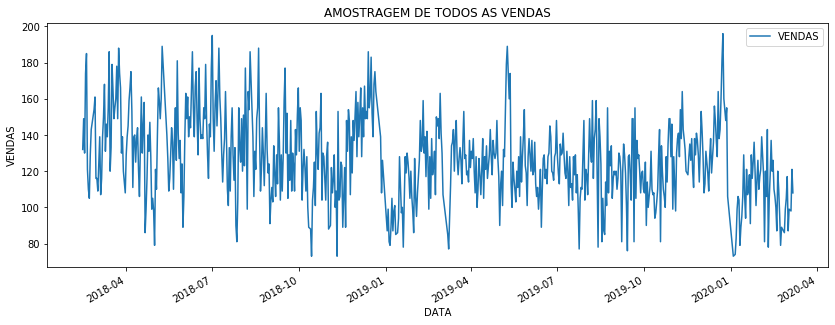

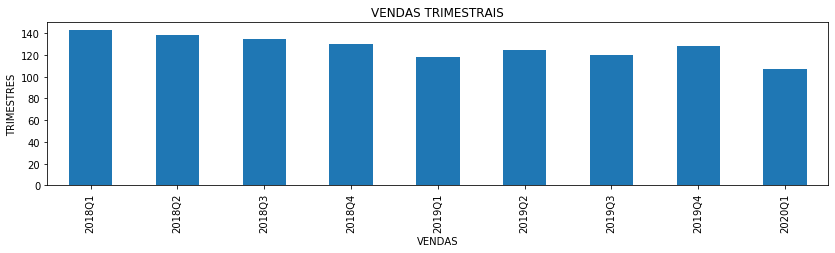

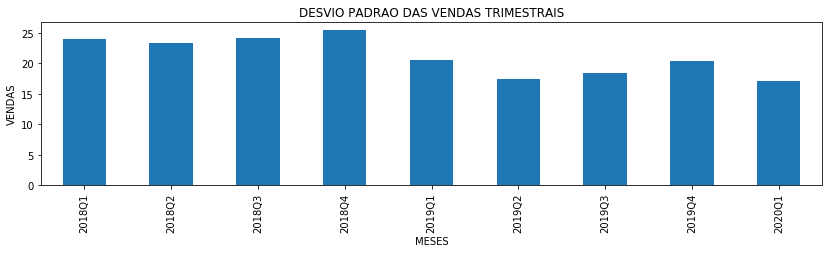

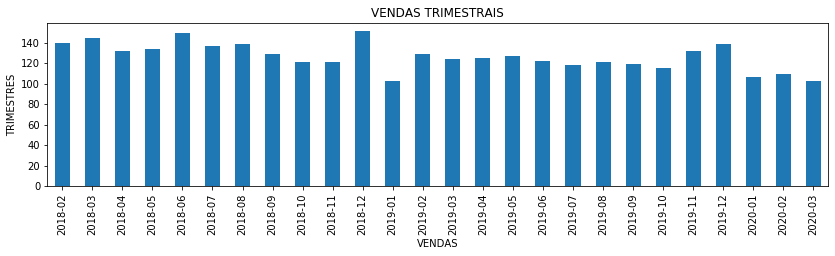

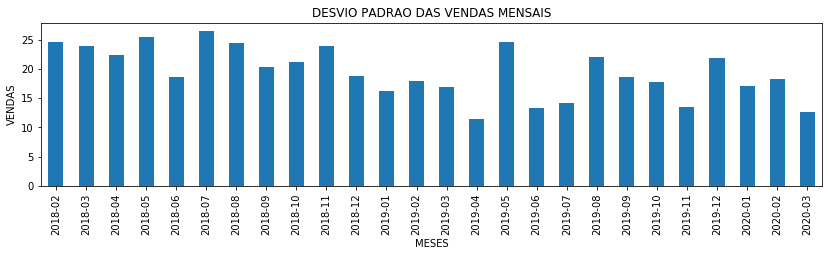

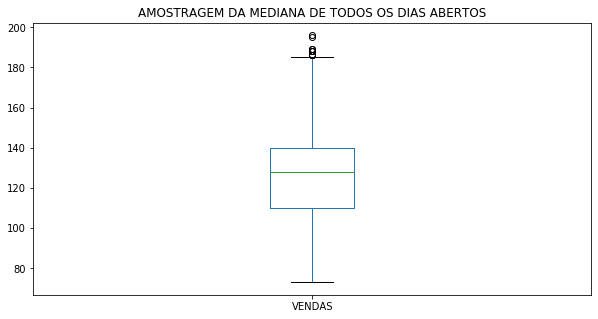

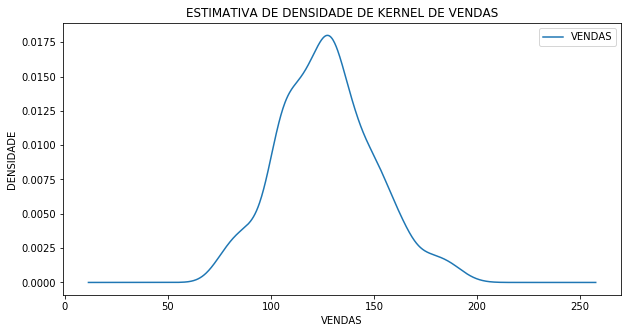

In [7]:
################################################ Periods and General Vision EDA
import matplotlib.pyplot as plt
import seaborn as sns

ax = df.plot(y=['VENDAS'], x='DATA', figsize=(14, 5))
plt.legend(loc=1)
plt.title('AMOSTRAGEM DE TODOS AS VENDAS')
plt.xlabel('DATA')
plt.ylabel('VENDAS')
plt.show()    

df_quarter = pd.DataFrame({'DATA': pd.to_datetime(df['DATA']), 'TEMPERATURA': df['TEMPERATURA'], 'VENDAS': df['VENDAS']})

df_quarter.groupby(df['DATA'].dt.to_period('Q'))['VENDAS'].agg('mean').plot(y='VENDAS', x='DATA', kind='bar', figsize=(14, 3))
plt.title('VENDAS TRIMESTRAIS')
plt.xlabel('VENDAS')
plt.ylabel('TRIMESTRES')
plt.show()

df_quarter.groupby(df['DATA'].dt.to_period('Q'))['VENDAS'].agg('std').plot(y='VENDAS', x='DATA', kind='bar', figsize=(14, 3))
plt.title('DESVIO PADRAO DAS VENDAS TRIMESTRAIS')
plt.xlabel('MESES')
plt.ylabel('VENDAS')
plt.show()

df_quarter.groupby(df['DATA'].dt.to_period('M'))['VENDAS'].agg('mean').plot(y='VENDAS', x='DATA', kind='bar', figsize=(14, 3))
plt.title('VENDAS TRIMESTRAIS')
plt.xlabel('VENDAS')
plt.ylabel('TRIMESTRES')
plt.show()

df_quarter.groupby(df['DATA'].dt.to_period('M'))['VENDAS'].agg('std').plot(y='VENDAS', x='DATA', kind='bar', figsize=(14, 3))
plt.title('DESVIO PADRAO DAS VENDAS MENSAIS')
plt.xlabel('MESES')
plt.ylabel('VENDAS')
plt.show()

df.plot(y='VENDAS', x='DATA', figsize=(10, 5), kind='box')
plt.title('AMOSTRAGEM DA MEDIANA DE TODOS OS DIAS ABERTOS')
plt.show()

df.plot(y='VENDAS', x='DATA', figsize=(10, 5), kind='kde')
plt.legend(loc=1)
plt.title('ESTIMATIVA DE DENSIDADE DE KERNEL DE VENDAS')
plt.xlabel('VENDAS')
plt.ylabel('DENSIDADE')
plt.show()

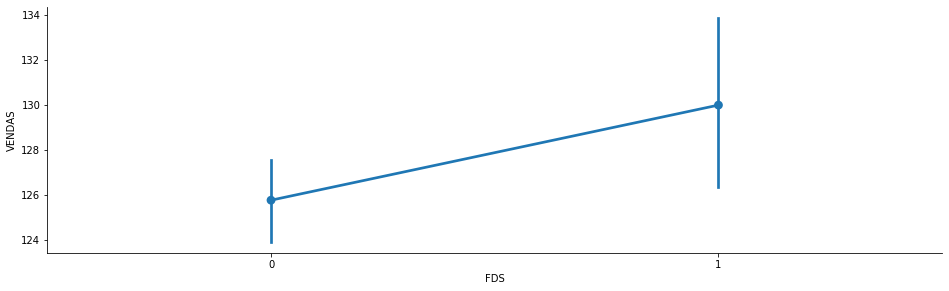

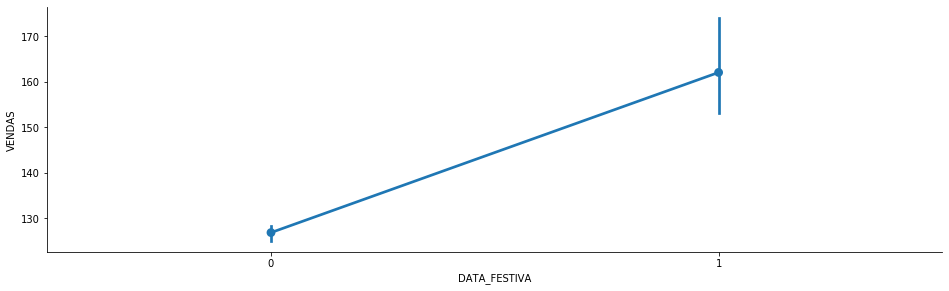

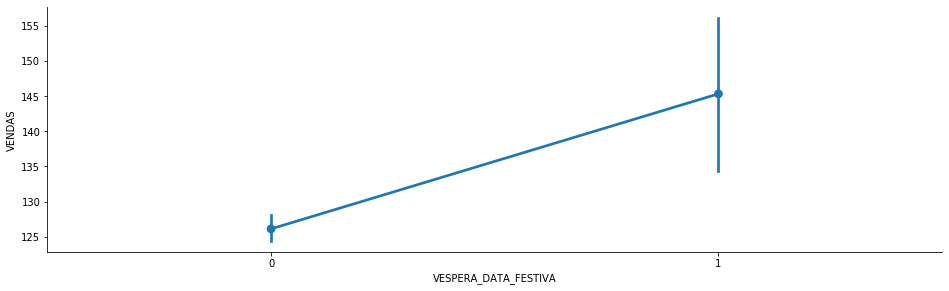

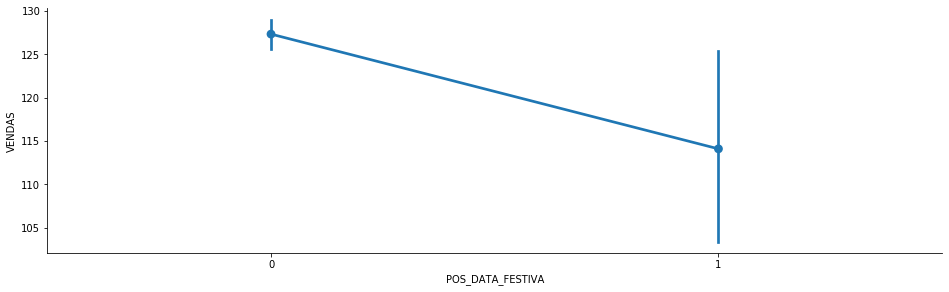

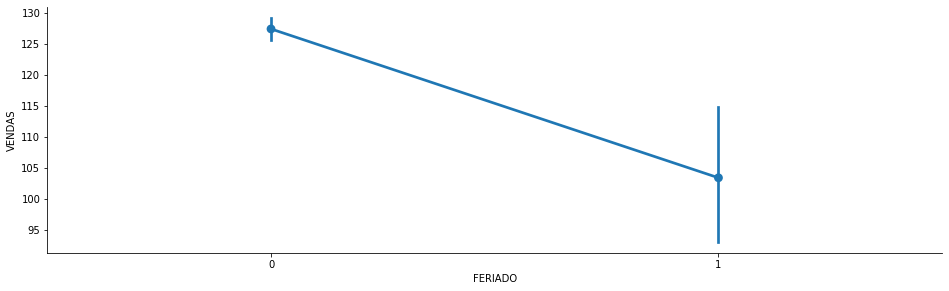

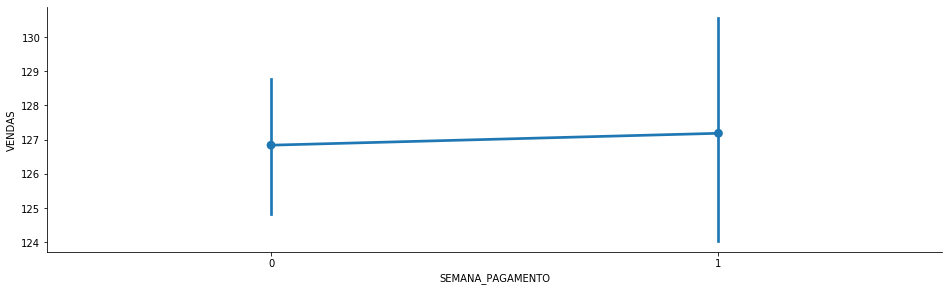

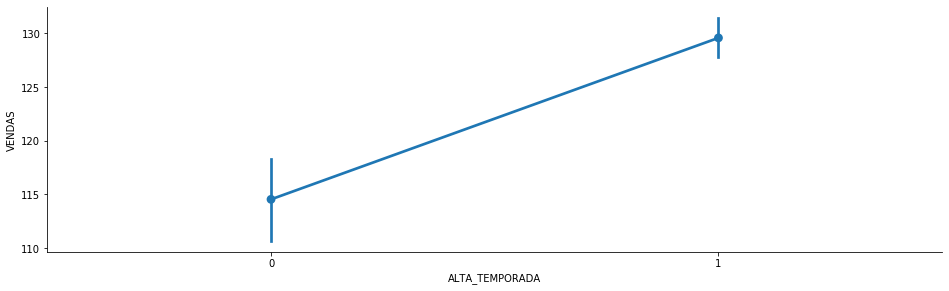

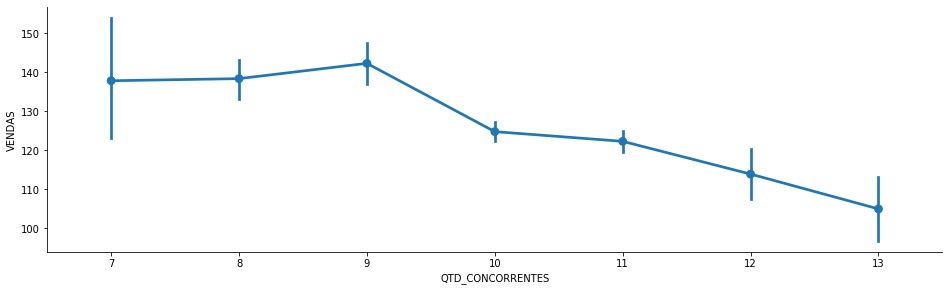

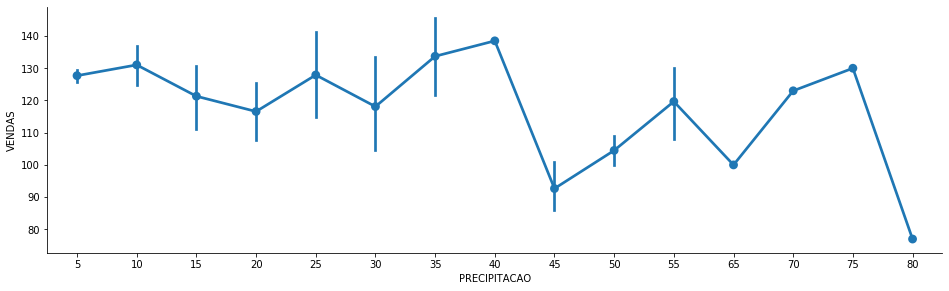

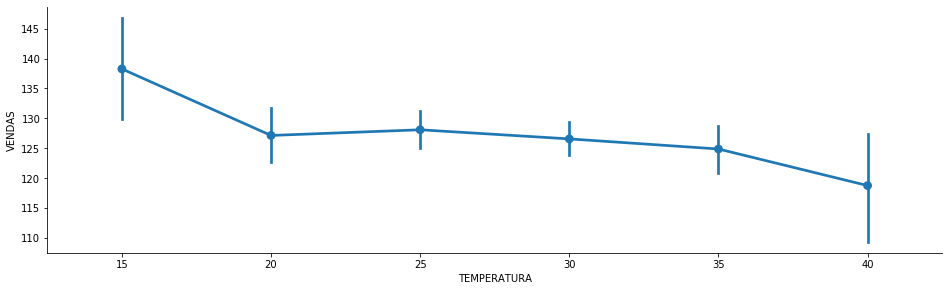

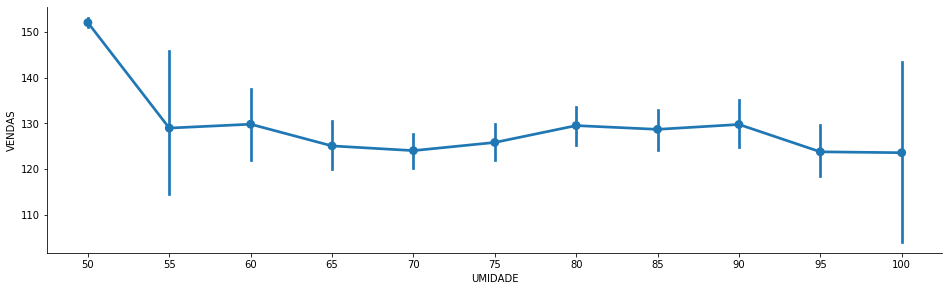

In [8]:
################################################ Columns EDA

df_scatter = df.sort_values(by=['VENDAS'], ascending=True)

c = sns.catplot('FDS', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('DATA_FESTIVA', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('VESPERA_DATA_FESTIVA', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('POS_DATA_FESTIVA', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('FERIADO', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('SEMANA_PAGAMENTO', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('ALTA_TEMPORADA', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('QTD_CONCORRENTES', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('PRECIPITACAO', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('TEMPERATURA', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('UMIDADE', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

In [9]:
################################################################################################################################################################################################
################################################################################################ GradientBoostingRegressor
################################################################################################################################################################################################

In [10]:
################################################ permutation importance
import numpy as np
import eli5

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor
from eli5.sklearn import PermutationImportance

# all columns
all_columns = ['DATA', 'VENDAS', 'FDS', 'DATA_FESTIVA', 'VESPERA_DATA_FESTIVA', 'POS_DATA_FESTIVA', 'FERIADO', 'SEMANA_PAGAMENTO', 'ALTA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 'TEMPERATURA', 'UMIDADE', 'VENDAS_MEDIA_TRIM', 'VENDAS_MEDIA_MES', 'VENDAS_STD_TRIM', 'VENDAS_STD_MES', 'VENDAS_ONTEM']

# creating feature dataset
features_to_drop_default = ['DATA', 'VENDAS']
features_to_drop_from_feature_analysis = ['SEMANA_PAGAMENTO', 'PRECIPITACAO']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis 

# creating target dataset
outputs_to_drop = ['DATA', 'FDS', 'DATA_FESTIVA', 'VESPERA_DATA_FESTIVA', 'POS_DATA_FESTIVA', 'FERIADO', 'SEMANA_PAGAMENTO', 'ALTA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 'TEMPERATURA', 'UMIDADE', 'VENDAS_MEDIA_TRIM', 'VENDAS_MEDIA_MES', 'VENDAS_STD_TRIM', 'VENDAS_STD_MES', 'VENDAS_ONTEM']

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X = df.drop(columns=features_to_drop)
y = df.drop(columns=outputs_to_drop)

# save features names
features = X.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.fit_transform(X)

# permutation importance
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

################################################ permutation importance 2nd Round

# creating feature dataset
features_to_drop_from_permutation = ['VENDAS_STD_MES', 'FDS', 'POS_DATA_FESTIVA', 'UMIDADE', 'TEMPERATURA', 'VESPERA_DATA_FESTIVA']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis + features_to_drop_from_permutation

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X = df.drop(columns=features_to_drop)
y = df.drop(columns=outputs_to_drop)

# save features names
features = X.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.fit_transform(X)

# permutation importance
nn = GradientBoostingRegressor()
nn.fit(X_train, y_train)
perm = PermutationImportance(nn, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

################################################ permutation importance 3rd Round
# creating feature dataset
features_to_drop_from_permutation_2nd_round = ['ALTA_TEMPORADA']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis + features_to_drop_from_permutation + features_to_drop_from_permutation + features_to_drop_from_permutation_2nd_round

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X = df.drop(columns=features_to_drop)
y = df.drop(columns=outputs_to_drop)

# save features names
features = X.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.fit_transform(X)

# permutation importance
nn = GradientBoostingRegressor()
nn.fit(X_train, y_train)
perm = PermutationImportance(nn, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

Weight,Feature
0.2419 ± 0.2312,VENDAS_ONTEM
0.0198 ± 0.0161,VENDAS_MEDIA_MES
0 ± 0.0000,VENDAS_STD_TRIM
0 ± 0.0000,VENDAS_MEDIA_TRIM
0 ± 0.0000,QTD_CONCORRENTES
0 ± 0.0000,FERIADO
0 ± 0.0000,DATA_FESTIVA


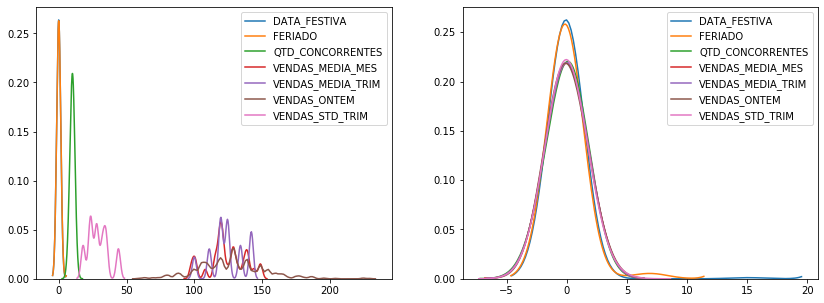

In [11]:
################################################ featured engineering
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# plot scaling
scaled_X_train = pd.DataFrame(X_train, columns=leftovers)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))

for i in range(len(leftovers)):
    column = leftovers[i]
    sns.kdeplot(df[column], bw=1.5, ax=ax1)

for j in range(len(leftovers)):
    column = leftovers[j]
    sns.kdeplot(scaled_X_train[column], bw=1.5, ax=ax2)

plt.show()

RMSE (cross validation): 18.49
MAE (cross validation): 13.97
RMSE: 18.39
MAE: 14.56
R2: -0.23


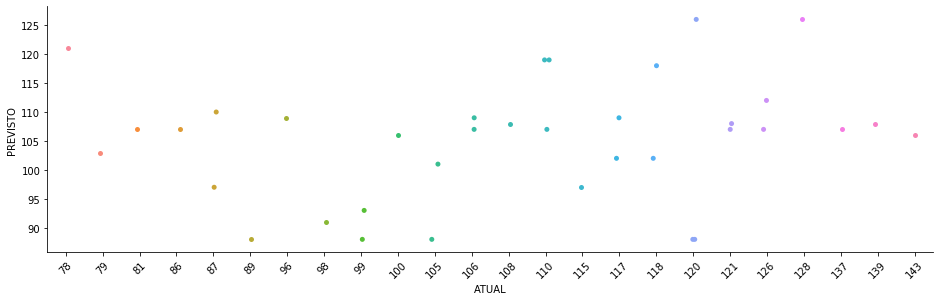

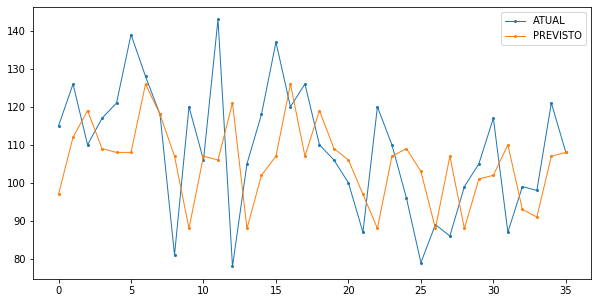

In [12]:
# imports
from sklearn.ensemble import GradientBoostingRegressor

# model
gb = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=25,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=21, min_samples_split=16,
                          min_weight_fraction_leaf=0.0, n_estimators=139,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# cross validation
scores_rmse = cross_val_score(gb, X, y, scoring='neg_root_mean_squared_error', cv=5)
scores_mae = cross_val_score(gb, X, y, scoring='neg_mean_absolute_error', cv=5)
print(f'RMSE (cross validation): %.2f' % np.abs(scores_rmse).min())
print(f'MAE (cross validation): %.2f' % np.abs(scores_mae).min())

# manual training
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test).round().astype(int)
print(f'RMSE: %.2f' % metrics.mean_squared_error(y_test, y_pred_gb, squared=False))
print(f'MAE: %.2f' % metrics.mean_absolute_error(y_test, y_pred_gb))
print(f'R2: %.2f' % metrics.r2_score(y_test, y_pred_gb))

# scatter
c = sns.catplot('ATUAL', 'PREVISTO', data=pd.DataFrame({'PREVISTO': y_pred_gb.flatten(), 'ATUAL': y_test.values.flatten() }))
c.set_xticklabels(rotation=45)
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

# plot
df1 = pd.DataFrame({'ATUAL': y_test.values.flatten(), 'PREVISTO': y_pred_gb.flatten()})
df1.plot(kind='line', figsize=(10, 5), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.show()

In [13]:
################################################################################################################################################################################################
################################################################################################ MLPRegressor
################################################################################################################################################################################################

In [14]:
################################################ permutation importance
import numpy as np
import eli5

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPRegressor
from eli5.sklearn import PermutationImportance

# all columns
all_columns = ['DATA', 'VENDAS', 'FDS', 'DATA_FESTIVA', 'VESPERA_DATA_FESTIVA', 'POS_DATA_FESTIVA', 'FERIADO', 'SEMANA_PAGAMENTO', 'ALTA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 'TEMPERATURA', 'UMIDADE', 'VENDAS_MEDIA_TRIM', 'VENDAS_MEDIA_MES', 'VENDAS_STD_TRIM', 'VENDAS_STD_MES', 'VENDAS_ONTEM']

# creating feature dataset
features_to_drop_default = ['DATA', 'VENDAS']
features_to_drop_from_feature_analysis = ['SEMANA_PAGAMENTO', 'PRECIPITACAO']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis 

# creating target dataset
outputs_to_drop = ['DATA', 'FDS', 'DATA_FESTIVA', 'VESPERA_DATA_FESTIVA', 'POS_DATA_FESTIVA', 'FERIADO', 'SEMANA_PAGAMENTO', 'ALTA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 'TEMPERATURA', 'UMIDADE', 'VENDAS_MEDIA_TRIM', 'VENDAS_MEDIA_MES', 'VENDAS_STD_TRIM', 'VENDAS_STD_MES', 'VENDAS_ONTEM']

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X = df.drop(columns=features_to_drop)
y = df.drop(columns=outputs_to_drop)

# save features names
features = X.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.fit_transform(X)

# permutation importance
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

################################################ permutation importance 2nd Round

# creating feature dataset
features_to_drop_from_permutation = ['TEMPERATURA', 'VESPERA_DATA_FESTIVA']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis + features_to_drop_from_permutation

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X = df.drop(columns=features_to_drop)
y = df.drop(columns=outputs_to_drop)

# save features names
features = X.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.fit_transform(X)

# permutation importance
nn = GradientBoostingRegressor()
nn.fit(X_train, y_train)
perm = PermutationImportance(nn, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

################################################ permutation importance 3rd Round
# creating feature dataset
features_to_drop_from_permutation_2nd_round = ['FDS', 'UMIDADE', 'ALTA_TEMPORADA']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis + features_to_drop_from_permutation + features_to_drop_from_permutation + features_to_drop_from_permutation_2nd_round

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X = df.drop(columns=features_to_drop)
y = df.drop(columns=outputs_to_drop)

# save features names
features = X.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.fit_transform(X)

# permutation importance
nn = GradientBoostingRegressor()
nn.fit(X_train, y_train)
perm = PermutationImportance(nn, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=features)

Weight,Feature
0.1198 ± 0.1478,VENDAS_ONTEM
0.0263 ± 0.0466,POS_DATA_FESTIVA
0.0003 ± 0.0231,VENDAS_STD_MES
0 ± 0.0000,VENDAS_STD_TRIM
0 ± 0.0000,VENDAS_MEDIA_TRIM
0 ± 0.0000,QTD_CONCORRENTES
0 ± 0.0000,FERIADO
0 ± 0.0000,DATA_FESTIVA
-0.0004 ± 0.0026,VENDAS_MEDIA_MES


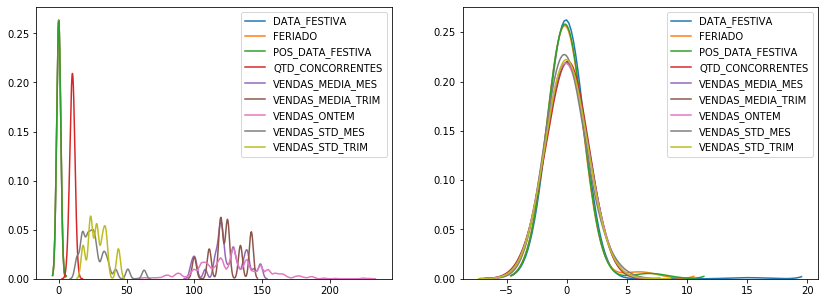

In [15]:
################################################ featured engineering
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# plot scaling
scaled_X_train = pd.DataFrame(X_train, columns=leftovers)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))

for i in range(len(leftovers)):
    column = leftovers[i]
    sns.kdeplot(df[column], bw=1.5, ax=ax1)

for j in range(len(leftovers)):
    column = leftovers[j]
    sns.kdeplot(scaled_X_train[column], bw=1.5, ax=ax2)

plt.show()

RMSE (cross validation): 16.26
MAE (cross validation): 12.88
RMSE: 16.26
MAE: 12.44
R2: 0.04


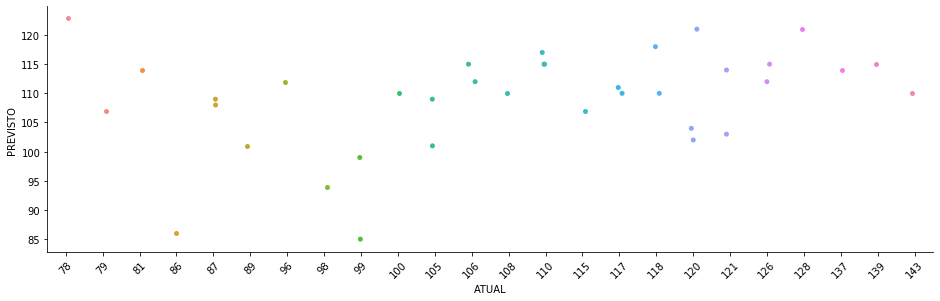

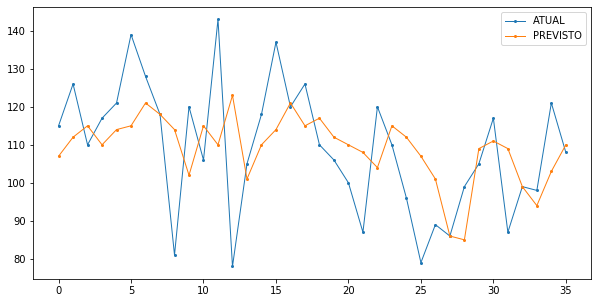

In [16]:
# imports
from sklearn.neural_network import MLPRegressor

# model
mlp = MLPRegressor(activation='identity', alpha=0.0001, batch_size=400, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(89), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=100,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

# cross validation
scores_rmse = cross_val_score(mlp, X, y, scoring='neg_root_mean_squared_error', cv=5)
scores_mae = cross_val_score(mlp, X, y, scoring='neg_mean_absolute_error', cv=5)
print(f'RMSE (cross validation): %.2f' % np.abs(scores_rmse).min())
print(f'MAE (cross validation): %.2f' % np.abs(scores_mae).min())

# manual training
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test).round().astype(int)
print(f'RMSE: %.2f' % metrics.mean_squared_error(y_test, y_pred_mlp, squared=False))
print(f'MAE: %.2f' % metrics.mean_absolute_error(y_test, y_pred_mlp))
print(f'R2: %.2f' % metrics.r2_score(y_test, y_pred_mlp))

# scatter
c = sns.catplot('ATUAL', 'PREVISTO', data=pd.DataFrame({'PREVISTO': y_pred_mlp.flatten(), 'ATUAL': y_test.values.flatten() }))
c.set_xticklabels(rotation=45)
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

# plot
df1 = pd.DataFrame({'ATUAL': y_test.values.flatten(), 'PREVISTO': y_pred_mlp.flatten()})
df1.plot(kind='line', figsize=(10, 5), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.show()

In [17]:
################################################################################################################################################################################################
################################################################################################ Ensemble
################################################################################################################################################################################################

In [18]:
from sklearn.ensemble import VotingRegressor

softvoting = VotingRegressor(estimators=[('gb', gb),('mlp', mlp)])
softvoting.fit(X, y)
y_pred = softvoting.predict(X_test).round().astype(int)
print(f'RMSE: %.2f' % metrics.mean_squared_error(y_test, y_pred, squared=False))

RMSE: 15.68


In [19]:
from mlxtend.regressor import StackingRegressor
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf')
stregr = StackingRegressor(regressors=[gb, mlp], meta_regressor=svr_rbf)
stregr.fit(X_train, y_train)
y_pred = stregr.predict(X_test).round().astype(int)
y_pred = y_pred.reshape(y_pred.shape[0], 1)
print(f'RMSE: %.2f' % metrics.mean_squared_error(y_test, y_pred, squared=False))

RMSE: 18.25


In [20]:
from sklearn.ensemble import BaggingRegressor

clfs = [gb, mlp]

for clf in clfs:
    vanilla_scores_rmse = cross_val_score(clf, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    bagging_clf = BaggingRegressor(clf)
    bagging_scores_rmse = cross_val_score(bagging_clf, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    print("RMSE: {1:.2f} [{0}]".format(clf.__class__.__name__, np.abs(vanilla_scores_rmse.mean())))
    print("RMSE: {1:.2f} [Bagging {0}]\n".format(clf.__class__.__name__, np.abs(bagging_scores_rmse.mean())))

RMSE: 20.86 [GradientBoostingRegressor]
RMSE: 20.07 [Bagging GradientBoostingRegressor]

RMSE: 18.52 [MLPRegressor]
RMSE: 18.60 [Bagging MLPRegressor]



In [21]:
################################################################################################################################################################################################
################################################################################################ LSTM
################################################################################################################################################################################################

In [22]:
################################################ permutation importance
import numpy as np
import eli5

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor
from eli5.sklearn import PermutationImportance

# all columns
all_columns = ['DATA', 'VENDAS', 'FDS', 'DATA_FESTIVA', 'VESPERA_DATA_FESTIVA', 'POS_DATA_FESTIVA', 'FERIADO', 'SEMANA_PAGAMENTO', 'ALTA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 'TEMPERATURA', 'UMIDADE', 'VENDAS_MEDIA_TRIM', 'VENDAS_MEDIA_MES', 'VENDAS_STD_TRIM', 'VENDAS_STD_MES', 'VENDAS_ONTEM']

# creating feature dataset
features_to_drop_default = ['DATA', 'VENDAS']
features_to_drop_from_feature_analysis = ['SEMANA_PAGAMENTO', 'PRECIPITACAO']
features_to_drop_from_feature_importance = ['TEMPERATURA', 'POS_DATA_FESTIVA', 'FDS', 'VESPERA_DATA_FESTIVA', 'ALTA_TEMPORADA', 'VENDAS_MEDIA_TRIM', 'VENDAS_STD_MES', 'VENDAS_STD_TRIM']
features_to_drop = features_to_drop_default + features_to_drop_from_feature_analysis + features_to_drop_from_feature_importance

# creating target dataset
outputs_to_drop = ['DATA', 'FDS', 'DATA_FESTIVA', 'VESPERA_DATA_FESTIVA', 'POS_DATA_FESTIVA', 'FERIADO', 'SEMANA_PAGAMENTO', 'ALTA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 'TEMPERATURA', 'UMIDADE', 'VENDAS_MEDIA_TRIM', 'VENDAS_MEDIA_MES', 'VENDAS_STD_TRIM', 'VENDAS_STD_MES', 'VENDAS_ONTEM']

# columns considered by the model
leftovers = np.setdiff1d(all_columns, features_to_drop) 
X = df.drop(columns=features_to_drop)
y = df.drop(columns=outputs_to_drop)

# save features names
features = X.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1, shuffle=False)

# feature scaling
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.fit_transform(X)

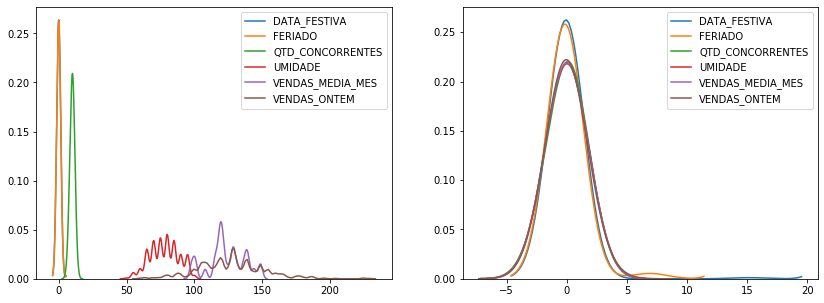

In [23]:
################################################ featured engineering
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# plot scaling
scaled_X_train = pd.DataFrame(X_train, columns=leftovers)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))

for i in range(len(leftovers)):
    column = leftovers[i]
    sns.kdeplot(df[column], bw=1.5, ax=ax1)

for j in range(len(leftovers)):
    column = leftovers[j]
    sns.kdeplot(scaled_X_train[column], bw=1.5, ax=ax2)

plt.show()

RMSE: 16.94
MAE: 13.69
R2: -0.04


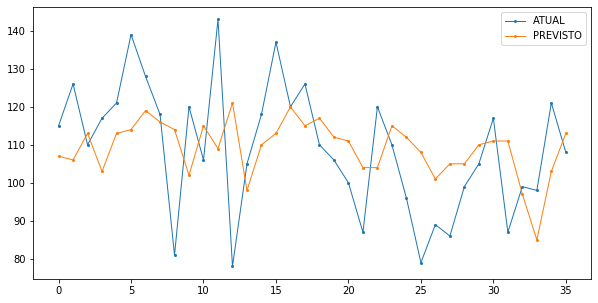

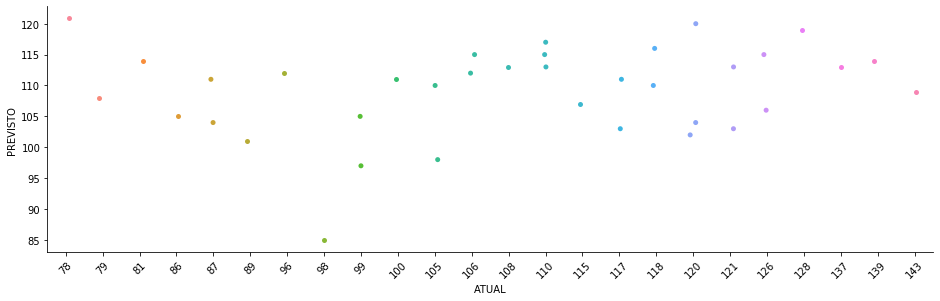

In [24]:
# imports
import seaborn as sns
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor

# reshape to 3D
train_X = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
train_y = np.array(y_train).reshape((y_train.shape[0], 1, y_train.shape[1]))
test_X = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
sizee = (int(train_X.shape[2] - 1) * -1)

# model
def base_model():
    lstm = Sequential()
    lstm.add(LSTM(190, return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(190, return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(190, return_sequences=False))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')
    return lstm
lstm = KerasRegressor(build_fn=base_model)

# manual training
lstm.fit(train_X, train_y, epochs=200, batch_size=20, shuffle=False, verbose=False)
y_pred_lstm = lstm.predict(test_X).round().astype(int)
y_pred_lstm = y_pred_lstm.reshape((y_pred_lstm.shape[0], 1))
test_X = test_X.reshape((test_X.shape[0], train_X.shape[2]))
rmse = metrics.mean_squared_error(y_test, y_pred_lstm, squared=False)
mae = metrics.mean_absolute_error(y_test, y_pred_lstm)
print(f'RMSE: %.2f' % rmse)
print(f'MAE: %.2f' % mae)
print(f'R2: %.2f' % metrics.r2_score(y_test, y_pred_lstm))

# plot
df1 = pd.DataFrame({'ATUAL': y_test.values.flatten(), 'PREVISTO': y_pred_lstm.flatten()})
df1.plot(kind='line', figsize=(10, 5), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.show()

# scatter
c = sns.catplot('ATUAL', 'PREVISTO', data=pd.DataFrame({'PREVISTO': y_pred_lstm.flatten(), 'ATUAL': y_test.values.flatten() }))
c.set_xticklabels(rotation=45)
c.fig.set_figwidth(15)
c.fig.set_figheight(4)